In [1]:
# to ignore the warning 
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import random 
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# print(tf.config.list_physical_devices('GPU'))



In [5]:
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [6]:
log_dir = '/mnt/c/Users/Rahul/Desktop/Document-and-Record-Management/notebooks/experiments/'

In [7]:
train_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/train/"
# test_ds = "../data/test data" # not yer made so as of right now we will be using only train and val 
val_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/val/"

In [8]:
batch_size = 12 
img_height, img_width = 500 , 500

In [9]:
train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [10]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 900 images belonging to 4 classes.


In [11]:
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 213 images belonging to 4 classes.


In [12]:
train_ds.image_shape

(500, 500, 3)

In [14]:
num_classes = 4

In [15]:
resnet= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',
                   weights='imagenet')
for layer in resnet.layers:
        layer.trainable=False


I0000 00:00:1724687683.379020  230677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724687683.406990  230677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724687683.407073  230677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724687683.409494  230677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724687683.409547  230677 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 58s 1us/step


In [16]:
# Determine 60% of the layers
num_layers_to_freeze = int(0.60* len(resnet.layers))

# Freeze the first 45% of layers
for i, layer in enumerate(resnet.layers):
    if i < num_layers_to_freeze:
        layer.trainable = False

In [17]:
model = Sequential([ resnet,
    layers.Flatten(), 
    layers.Dense(448, activation='relu'),
    layers.Dense(240, activation='relu'),
    layers.Dense(112, activation='relu'),
    layers.Dropout(0.4), 
    layers.Dense(num_classes, activation='softmax')])

In [18]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 240)            │       107,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 112)            │        26,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,868 (94.00 MB)

 Trainable params: 1,053,156 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
model.compile(optimizer=Adam(learning_rate=4e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"] 
             )

In [20]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, 
  )

Epoch 1/10


I0000 00:00:1724687789.214813  234050 service.cc:146] XLA service 0x7efb90002e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724687789.215014  234050 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-26 21:41:29.389541: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 21:41:30.223979: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/75 ━━━━━━━━━━━━━━━━━━━━ 18:06 15s/step - accuracy: 0.5833 - loss: 1.2392

I0000 00:00:1724687798.877434  234050 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - accuracy: 0.4336 - loss: 1.4008 - val_accuracy: 0.9202 - val_loss: 0.4223
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.8883 - loss: 0.3529 - val_accuracy: 0.9577 - val_loss: 0.1626
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.9622 - loss: 0.1589 - val_accuracy: 0.9765 - val_loss: 0.1091
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.9760 - loss: 0.1107 - val_accuracy: 0.9718 - val_loss: 0.0865
Epoch 5/10
30/75 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9977 - loss: 0.0339

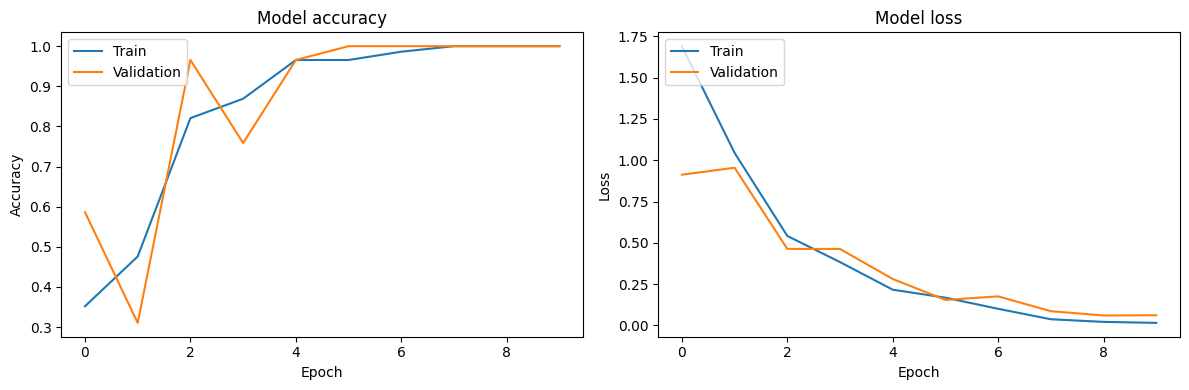

In [51]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
model.save("./resnet50.h5")